In [33]:
# CNN does what it’s good at → images

# MLP does what it’s good at → tabular data

# Model learns complementary information

Classifying uterine abnormalities to assist in infertility diagnosis



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, average_precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report


import pandas as pd
import tensorflow as tf
from sklearn.decomposition import PCA
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC    
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
import seaborn as sns
import numpy as np
import cv2
import os
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [116]:
df = pd.read_csv(r'Data\Dataset.csv')
df

,id,log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity,log-sigma-1-0-mm-3D_ngtdm_Coarseness,minor_axis_length,area,log-sigma-1-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_ngtdm_Coarseness,log-sigma-2-0-mm-3D_gldm_DependenceNonUniformity,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformity,wavelet-H_ngtdm_Coarseness,...,wavelet-H_glcm_JointEntropy,wavelet-H_glrlm_GrayLevelNonUniformityNormalized,log-sigma-2-0-mm-3D_glrlm_GrayLevelNonUniformityNormalized,log-sigma-1-0-mm-3D_glrlm_HighGrayLevelRunEmphasis,log-sigma-2-0-mm-3D_glcm_MCC,LBP_hist_bin_7,log-sigma-1-0-mm-3D_gldm_HighGrayLevelEmphasis,label,unexplained_infertility,previous_miscarriages
0,1,4809.535706,0.000247,198.625804,34583,12731.61441,0.000467,13018.03444,2687.906126,0.000138,...,3.863600,0.275603,0.205812,110.158185,0.839618,0.054680,111.058150,0,0,0
1,2,4460.623751,0.000284,193.191790,32053,11900.13194,0.000526,11521.54435,2826.917297,0.000162,...,4.119202,0.252179,0.187636,72.062320,0.853366,0.063489,72.682151,0,0,0
2,3,4925.207181,0.000240,199.327172,34346,13081.91446,0.000431,13580.04041,2784.541071,0.000135,...,3.434695,0.314459,0.231505,56.084546,0.845357,0.060094,56.346329,0,0,0
3,4,4664.352654,0.000257,195.713530,34131,12645.47833,0.000490,12945.91348,2610.770111,0.000141,...,3.599379,0.297244,0.199265,72.034173,0.868814,0.058949,72.831414,0,0,0
4,5,4420.923359,0.000271,196.147021,32842,12027.18696,0.000530,11766.90250,2474.527556,0.000152,...,3.922065,0.272541,0.179913,72.190030,0.855325,0.061050,72.673284,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,124,4568.094233,0.000288,219.654077,39686,14367.67661,0.000472,14273.76697,3055.538006,0.000139,...,3.333863,0.321830,0.175555,90.434190,0.869936,0.069445,90.857481,1,0,1
124,125,4664.626825,0.000275,218.066669,39662,14590.95351,0.000430,14823.92587,3175.472188,0.000136,...,3.076035,0.349690,0.193674,72.112061,0.883472,0.069538,72.611845,1,1,0
125,126,5203.038054,0.000240,229.486021,41192,14904.76695,0.000434,14441.28705,3412.583833,0.000128,...,4.018386,0.262754,0.175031,72.478047,0.846720,0.072174,72.935619,1,0,1
126,127,5362.058473,0.000235,227.372063,40050,14744.51181,0.000405,14445.17743,3592.559575,0.000131,...,4.098497,0.255446,0.195726,110.253146,0.847308,0.059026,110.723695,1,1,0


In [117]:
tabular_features = df.drop(['id', 'label', 'unexplained_infertility'], axis=1)
labels = df['label']


In [118]:
corr_matrix = tabular_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
tabular_features = tabular_features.drop(to_drop, axis=1)
print(f"Dropped {len(to_drop)} redundant features.")

Dropped 234 redundant features.


In [119]:
height, width = 256, 256 
batch_size=32

In [120]:
image_folder = r"C:\Users\wesal\OneDrive\Desktop\Junior-fall\Machine Learning\Uterine-Abnormality\Ultrasound-Based-Classification-of-Uterine-Abnormalities\data\images"


image_list = []

for img_id in df['id']:
    img_name = f"{int(img_id):04d}" 
    img_name += '.jpg'
    
    img_path = os.path.join(image_folder, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: image not found -> {img_path}")
        continue
    
    img = img / 255.0
    
    img = img[..., np.newaxis]
    
    image_list.append(img)

X_img = np.array(image_list, dtype=np.float32)
print("Images loaded:", X_img.shape)

Images loaded: (128, 256, 256, 1)


In [121]:
X_img_temp, X_img_test, X_tab_temp, X_tab_test, y_temp, y_test = train_test_split(
    X_img, tabular_features, labels, test_size=0.15, random_state=42, stratify=labels
)
X_img_train, X_img_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_img_temp, X_tab_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

In [122]:
selector = SelectKBest(score_func=f_classif, k=50)
selector.fit(X_tab_train, y_train)
selected_cols = X_tab_train.columns[selector.get_support()]

In [123]:
temp_df = pd.DataFrame(selector.transform(X_tab_train), columns=selected_cols)
temp_df['target'] = y_train.values

corrs = temp_df.corr()['target'].abs()
important_features = corrs[corrs > 0.2].index.tolist()
if 'previous_miscarriages' not in important_features:
    important_features.append('previous_miscarriages')
if 'target' in important_features: important_features.remove('target')

print(f"Features after Step 2 (Target Corr > 0.2): {len(important_features)}")

Features after Step 2 (Target Corr > 0.2): 28


In [124]:
def select_uncorrelated_features(df, target_col, threshold=0.80):
    corr_matrix = df.drop(columns=[target_col]).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return [col for col in df.columns if col not in to_drop and col != target_col]

In [125]:
final_feature_names = select_uncorrelated_features(
    temp_df[important_features + ['target']], 
    target_col='target', 
    threshold=0.80
)

X_tab_train = temp_df[final_feature_names].values
X_tab_val   = X_tab_val[final_feature_names].values
X_tab_test  = X_tab_test[final_feature_names].values

print(f"Final features for Model: {len(final_feature_names)}")
print(f"Features: {final_feature_names}")

Final features for Model: 12
Features: ['log-sigma-1-0-mm-3D_glrlm_GrayLevelNonUniformity', 'eccentricity', 'log-sigma-2-0-mm-3D_firstorder_Maximum', 'wavelet-H_glcm_Imc1', 'log-sigma-3-0-mm-3D_firstorder_Mean', 'LBP_hist_bin_12', 'LBP_hist_bin_14', 'log-sigma-3-0-mm-3D_ngtdm_Contrast', 'wavelet-H_glrlm_RunLengthNonUniformity', 'wavelet-L_glcm_Correlation', 'wavelet-L_glrlm_GrayLevelNonUniformityNormalized', 'previous_miscarriages']


In [126]:
scaler = StandardScaler()
X_tab_train = scaler.fit_transform(X_tab_train)
X_tab_val = scaler.transform(X_tab_val)
X_tab_test = scaler.transform(X_tab_test)

print(f"Data ready. Final tabular features: {X_tab_train.shape[1]}")

Data ready. Final tabular features: 12


In [127]:
image_input = Input(shape=(256, 256, 1))
x = RandomFlip("horizontal")(image_input)
x = RandomRotation(0.1)(x)   
x = RandomZoom(0.1)(x)  

x = Conv2D(32, (3,3), kernel_regularizer=l2(1e-4), padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)

x = Conv2D(64, (3,3), kernel_regularizer=l2(1e-4),  padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = MaxPooling2D((3,3))(x)
# x = Flatten()(x)
x = Conv2D(128, (3,3), kernel_regularizer=l2(1e-4) , padding='same')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = GlobalAveragePooling2D()(x)

x = Dense(64,     kernel_regularizer=l2(1e-4), activation='relu')(x)
x = Dropout(0.3)(x)
#GAP keeps the essence of each feature map, but dramatically reduces model size.



# MLP for tabular
tab_input = Input(shape=(X_tab_train.shape[1],))
y = Dense(64, kernel_regularizer=l2(1e-4))(tab_input)
y = BatchNormalization()(y)
y = tf.keras.layers.ReLU()(y)
y = Dropout(0.3)(y)
y = Dense(64, activation='relu')(y)

#fusion
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.3)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, tab_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=5e-5), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 256, 256,  │          0 │ input_layer_2[0]… │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 256, 256,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 256, 256,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │        320 │ random_zoom_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 85, 85,    │          0 │ re_lu_4[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 85, 85,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 85, 85,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 85, 85,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 28, 28,    │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │        832 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                 

 Total params: 115,393 (450.75 KB)

 Trainable params: 114,817 (448.50 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss', 
    save_best_only=True,  
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,       
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    [X_img_train, X_tab_train], y_train,
    validation_data=([X_img_val, X_tab_val], y_val),
    epochs=500,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.5000 - loss: 0.7524 - val_accuracy: 0.6000 - val_loss: 0.7048
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4773 - loss: 0.7875 - val_accuracy: 0.5500 - val_loss: 0.7034
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4886 - loss: 0.7779 - val_accuracy: 0.6000 - val_loss: 0.7019
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3864 - loss: 0.8025 - val_accuracy: 0.6000 - val_loss: 0.6999
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5000 - loss: 0.7282 - val_accuracy: 0.6000 - val_loss: 0.6977
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3864 - loss: 0.8159 - val_accuracy: 0.6000 - val_loss: 0.6956
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5114 - loss: 0.7583 - val_accuracy: 0.6000 - val_loss: 0.6934
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4205 - loss: 0.7844 - val_accuracy: 0.6000 - val_loss: 0.6912
Epoch

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

def model_predict_wrapper(X_tab_combined):
    return model.predict([X_img_test, X_tab_combined], verbose=0)

results = permutation_importance(
    model_predict_wrapper, X_tab_test, y_test, n_repeats=10, random_state=42
)

plt.figure(figsize=(10, 6))
sorted_idx = results.importances_mean.argsort()
plt.boxplot(results.importances[sorted_idx].T, vert=False, labels=np.array(final_feature_names)[sorted_idx])
plt.title("Feature Importance (Tabular Branch)")
plt.xlabel("Decrease in Accuracy when feature is removed")
plt.show()

In [ ]:
def evaluate_set(images, tabular, labels, set_name):
    probs = model.predict([images, tabular], verbose=0).ravel()
    preds = (probs > 0.5).astype(int)
    
    acc = accuracy_score(labels, preds)
    auc_val = roc_auc_score(labels, probs)
    ap = average_precision_score(labels, probs)
    
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f"\n{'='*25} {set_name.upper()} REPORT {'='*25}")
    print(f"Accuracy:    {acc:.4f}")
    print(f"ROC AUC:     {auc_val:.4f} (Ability to separate classes)")
    print(f"PR AUC (AP): {ap:.4f} (Precision across thresholds)")
    print(f"Sensitivity: {sensitivity:.4f} (Ability to find Abnormal cases)")
    print(f"Specificity: {specificity:.4f} (Ability to find Normal cases)")
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=['Normal', 'Abnormal']))
    
    return cm, acc

cm_val, acc_val = evaluate_set(X_img_val, X_tab_val, y_val, "Validation")
cm_test, acc_test = evaluate_set(X_img_test, X_tab_test, y_test, "Test")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', ax=ax[0],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[0].set_title(f'Validation Confusion Matrix\nAccuracy: {acc_val:.2f}')
ax[0].set_ylabel('Actual Label')
ax[0].set_xlabel('Predicted Label')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
ax[1].set_title(f'Test Confusion Matrix\nAccuracy: {acc_test:.2f}')
ax[1].set_ylabel('Actual Label')
ax[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')


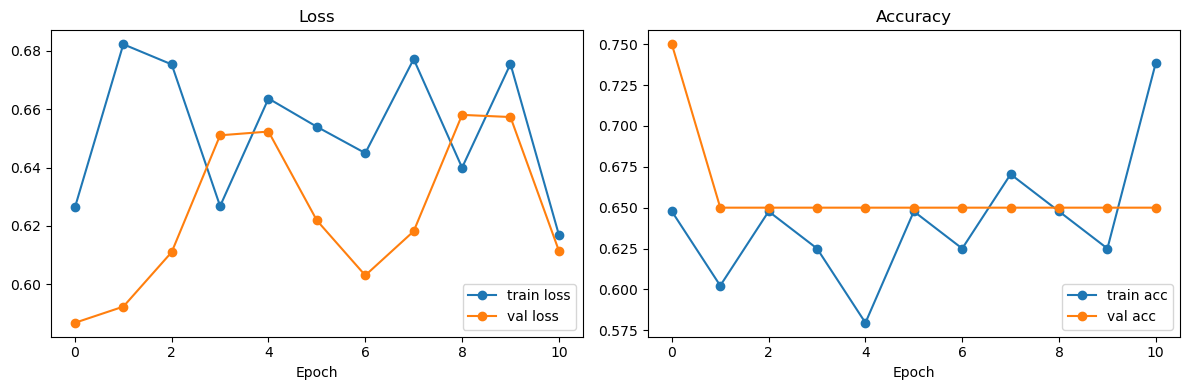

In [ ]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss', markersize=4)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss', markersize=4)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

acc = history_dict.get('accuracy') or history_dict.get('acc')
val_acc = history_dict.get('val_accuracy') or history_dict.get('val_acc')

plt.subplot(1, 2, 2)
if acc:
    plt.plot(epochs, acc, 'bo-', label='Training Acc', markersize=4)
    plt.plot(epochs, val_acc, 'ro-', label='Validation Acc', markersize=4)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='teal')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='teal')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
y_prob = model.predict([X_img_test, X_tab_test]).ravel()

plt.figure(figsize=(8, 5))
plt.hist(y_prob, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.axvline(0.35, color='red', linestyle='--', linewidth=2, label='Clinical Threshold (0.35)')

plt.title('Distribution of Model Confidence (Test Set)')
plt.xlabel('Predicted Probability of Abnormality')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()

NameError: name 'all_y_prob' is not defined

<Figure size 800x500 with 0 Axes>